Helper notebook for HW5, AMATH 582/482 Winter 2022.

In [ ]:
# Packages you will need 

import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cvx
import skimage as ski

import skimage.io
import skimage.transform

import scipy.fftpack as spfft # for discrete cosine transform 

# link Gdrive if using colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Original size:  (292, 228)
Rescaled size:  (53, 41)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Non RGB image conversion is now deprecated. For RGBA images, please use rgb2gray(rgba2rgb(rgb)) instead. In version 0.19, a ValueError will be raised if input image last dimension length is not 3.
  if __name__ == '__main__':


Text(0.5, 1.0, 'Rescaled image')

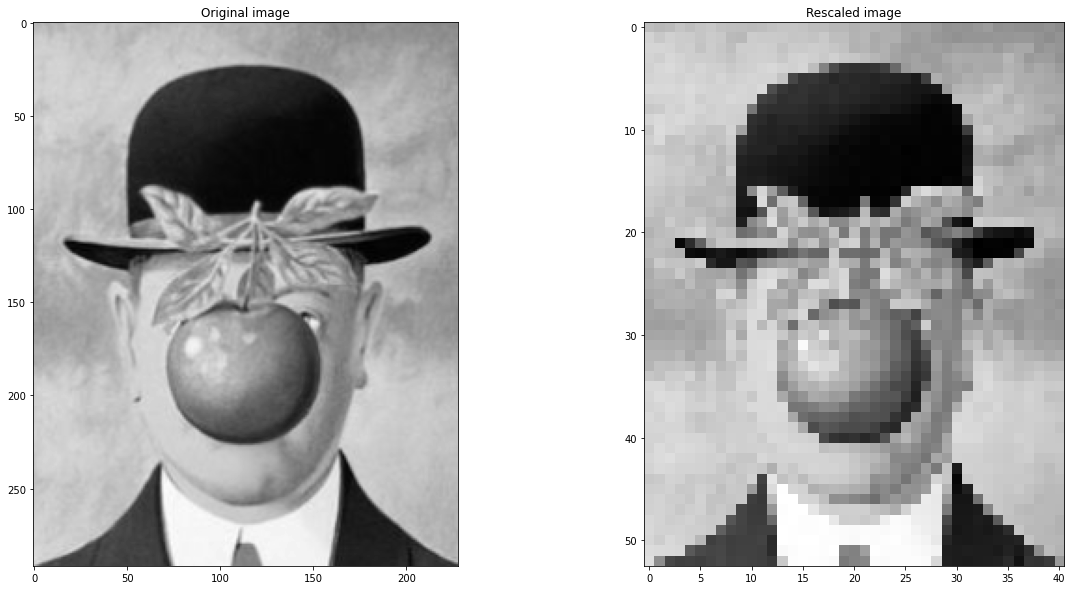

In [ ]:
# import image and rescale 

img_path = '/content/drive/My Drive/Colab Notebooks/SonOfMan.png'

# read image
img_og = ski.io.imread(img_path)

# convert to grayscale and visualize 
img_og = ski.color.rgb2gray(img_og)

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(img_og, cmap = 'gray')
ax[0].set_title("Original image")

print("Original size: ", img_og.shape) # 292x228

# resize image 
img = ski.transform.rescale( img_og, 0.18, anti_aliasing=False)

print("Rescaled size: ", img.shape) # 53x41

ax[1].imshow(img, cmap='gray')
ax[1].set_title("Rescaled image")

In [ ]:
# constrauct forward and inverse DCT matrices 

# construct DCT matrix
def construct_DCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: D DCT matrix mapping image.flatten() to 
  #         DCT(image).flatten()

  Dx = spfft.dct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.dct(np.eye(Ny), axis = 0, norm='ortho')

  D = np.kron(Dy, Dx)

  return D

# construct inverse DCT matrix
def construct_iDCT_Mat( Nx, Ny ):

  # input : Nx number of columns of image 
  #         Ny number of rows of image 

  # output: iD iDCT matrix mapping DCT(image).flatten() to 
  #         image.flatten()

  Dx = spfft.idct(np.eye(Nx), axis =0, norm='ortho')

  Dy = spfft.idct(np.eye(Ny), axis = 0, norm = 'ortho')

  D = np.kron(Dy, Dx)

  return D

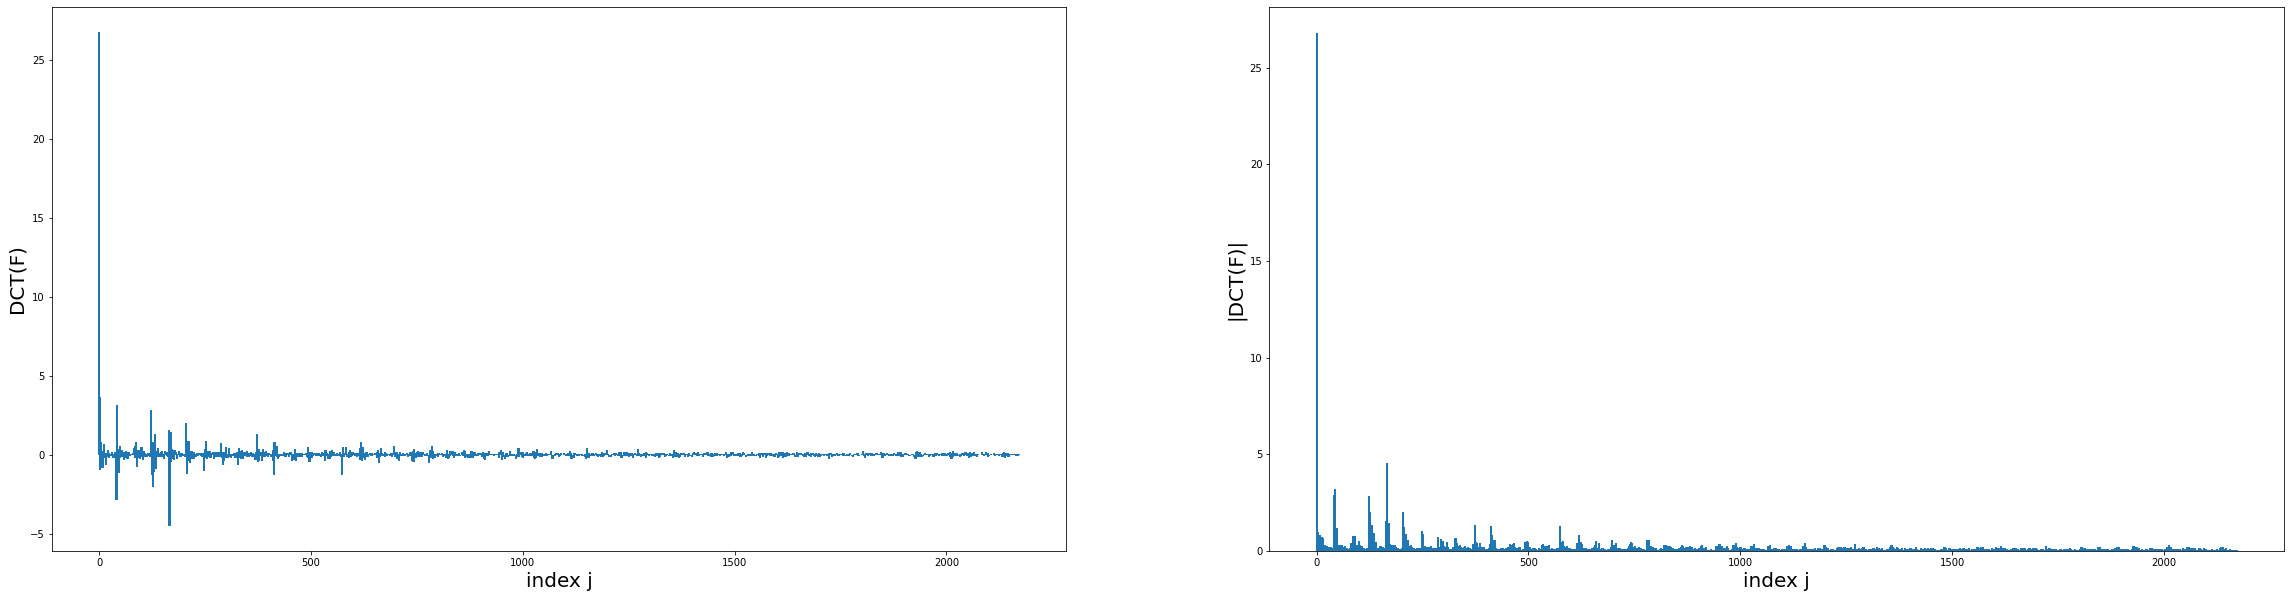

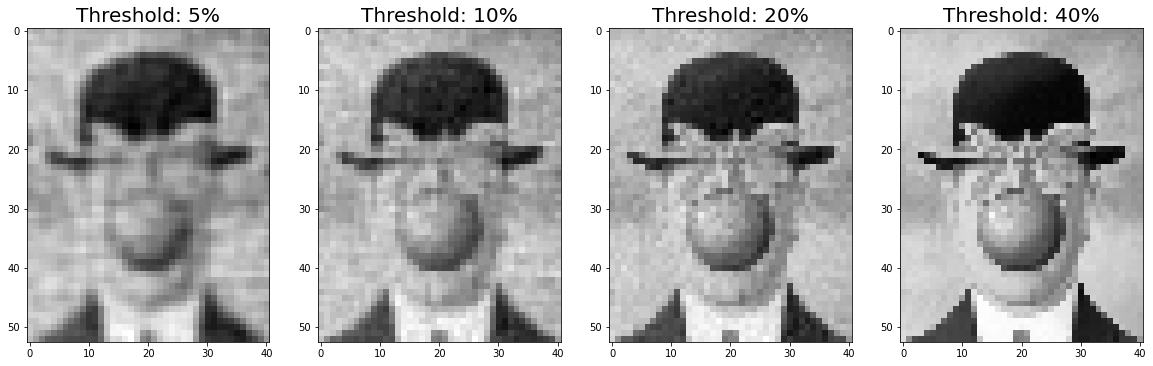

In [ ]:
### TASK 1: IMAGE COMPRESSION 
### Investigate the compressibility of the discrete cosine transform (DCT) of SonOfMan.png. 

### (a) Use construct_DCT_Mat and construct_iDCT_Mat to construct the 
### forward and inverse DCT matrices for the image. 
Ny = img.shape[0] # image rows 
Nx = img.shape[1] # image cols 
N = Ny * Nx # number of pixels in image 

# D*vecF = vec(DCT(F)) and iD*vec(DCT(F)) = vecF
vecF = img.flatten() # vectorized image F aka vec(F)
D = construct_DCT_Mat(Nx, Ny) # forward DCT matrix, D
iD = construct_iDCT_Mat(Nx, Ny) # inverse DCT matrix, D^{-1}

### (b) Plot DCT(F) and investigate its compressibility. 
### Do you see a lot of large coefficients? 
DCT_F = np.matmul(D, vecF) # vec(DCT(F)), shape = Nx1
fig, ax = plt.subplots(1,2,figsize=(40,10))
ax[0].bar(np.arange(N), DCT_F, width=5)
ax[0].set_xlabel('index j', fontsize=20)
ax[0].set_ylabel('DCT(F)', fontsize=20)
ax[1].bar(np.arange(N), np.abs(DCT_F), width=5)
ax[1].set_xlabel('index j', fontsize=20)
ax[1].set_ylabel('|DCT(F)|', fontsize=20)

### (c) Reconstruct and plot the image after thresholding its 
### DCT to keep the top 5, 10, 20, 40 percent of DCT coefficients. 
topPercents = [5, 10, 20, 40] 
fig, ax = plt.subplots(1,4,figsize=(20,80))
for index, percent in enumerate(topPercents):
  # Threshold 
  threshold = np.percentile(DCT_F, 100 - percent) # (100-percent)th percentile value 
  DCT_F_threshold = [value if np.abs(value) >= threshold else 0 for value in DCT_F] # everything below threshold becomes 0 

  # Compute new vec(F)
  vecF_new = np.matmul(iD, DCT_F_threshold)

  # Reshape vec(F) --> this is the new image 
  img_new = np.reshape(vecF_new, (Ny, Nx))

  # Plot image 
  ax[index].imshow(img_new, cmap = 'gray')
  ax[index].set_title('Threshold: ' + str(percent) + '%', fontsize=20)



     pcost       dcost       gap    pres   dres   k/t
 0: -1.3149e-14 -4.7768e-15  1e+04  4e+02  4e-16  1e+00
 1:  3.2157e+01  3.2287e+01  6e+03  2e+02  3e-16  6e-01
 2:  4.8125e+01  4.8452e+01  2e+03  6e+01  3e-16  5e-01
 3:  7.2639e+01  7.2791e+01  1e+03  3e+01  2e-16  2e-01
 4:  9.7099e+01  9.7161e+01  4e+02  1e+01  4e-16  9e-02
 5:  1.1673e+02  1.1676e+02  2e+02  5e+00  4e-16  4e-02
 6:  1.2553e+02  1.2554e+02  7e+01  2e+00  5e-16  2e-02
 7:  1.2978e+02  1.2978e+02  3e+01  9e-01  5e-16  7e-03
 8:  1.3136e+02  1.3137e+02  1e+01  4e-01  5e-16  3e-03
 9:  1.3216e+02  1.3216e+02  5e+00  2e-01  6e-16  1e-03
10:  1.3242e+02  1.3242e+02  3e+00  8e-02  7e-16  6e-04
11:  1.3257e+02  1.3257e+02  1e+00  3e-02  6e-16  2e-04
12:  1.3264e+02  1.3264e+02  4e-01  1e-02  5e-16  1e-04
13:  1.3266e+02  1.3266e+02  2e-01  5e-03  6e-16  4e-05
14:  1.3267e+02  1.3267e+02  6e-02  2e-03  7e-16  1e-05
15:  1.3268e+02  1.3268e+02  3e-02  8e-04  5e-16  6e-06
16:  1.3268e+02  1.3268e+02  1e-02  4e-04  5e-16  

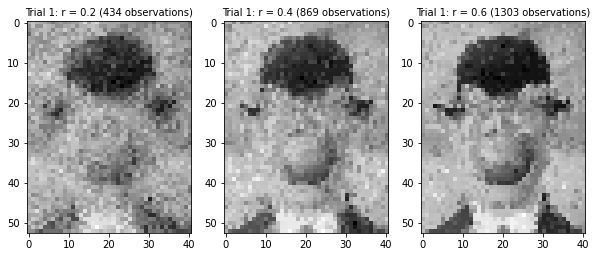

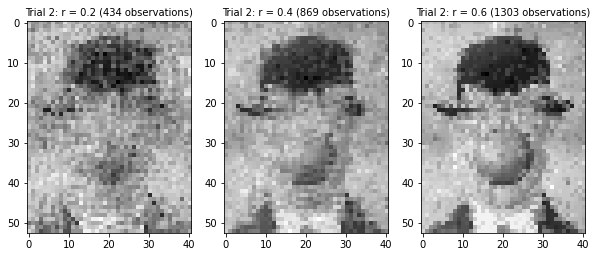

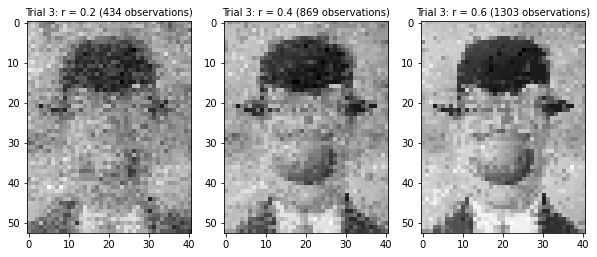

In [21]:
### TASK 2: COMPRESSED IMAGE RECOVERY 
### (a) Contruct a measurement matrix B by randomly selecting M rows of the 
### identity matrix I (HINT: numpy.random.permutation).
def compressed_image_recovery(trial):
  I = np.eye(N)
  B_all = np.random.permutation(I) # randomly mixes the rows of I
  rs = [0.2, 0.4, 0.6]
  fig, ax = plt.subplots(1, 3, figsize=(10, 30))
  for index, r in enumerate(rs):
    M = int(r*N)
    B = B_all[0:M,] # pick first M rows 

    ### (b) Generate a vector of measurements y by applying B to vec(F). 
    y = np.matmul(B, vecF)

    ### (c) Define the matrix A = BD^{-1} and use CVX to solve the optimization problem
    ### and denote the minimizer as x*. This vector x* is the DCT vector of an image F*
    ### that resembles the original image F. 
    A = np.matmul(B, iD)
    x = cvx.Variable(N)
    objective = cvx.Minimize( cvx.norm( x, 1 ) )
    constraints = [A*x == y]
    problem = cvx.Problem( objective, constraints )
    x_star = problem.solve(verbose=True, solver='CVXOPT', max_iter=1000, reltol=1e-2, featol=1e-2)

    vecF_star = np.matmul(iD, x.value)
    img_star = np.reshape(vecF_star, (Ny, Nx))

    ax[index].imshow(img_star, cmap = 'gray')
    ax[index].set_title('Trial ' + str(trial) + ': r = ' + str(r) + ' (' + str(M) + ' observations)', fontsize=10)


### (d) Take M = r*N for r = 0.2, 0.4, 0.6. For each choice of M, perform the steps 
### (a)-(c) to obtain an approximation F* to F and repeat these calculations 3 times
### by redrawing the random matrix B. Entire calculation should lead to a total of 
### 9 images that approximate the original image F. Plot these images and discuss results. 
for trial in range(1,3+1): 
  compressed_image_recovery(trial)


     pcost       dcost       gap    pres   dres   k/t
 0:  2.9670e-14  1.9822e-14  3e+04  1e+03  1e-15  1e+00
 1:  2.9658e+01  3.0189e+01  1e+04  3e+02  3e-16  8e-01
 2:  7.2764e+01  7.2857e+01  1e+03  4e+01  3e-16  1e-01
 3:  2.0177e+02  2.0179e+02  3e+02  8e+00  6e-16  3e-02
 4:  2.8074e+02  2.8075e+02  1e+02  3e+00  1e-15  1e-02
 5:  3.0448e+02  3.0449e+02  4e+01  1e+00  1e-15  5e-03
 6:  3.1328e+02  3.1329e+02  2e+01  6e-01  1e-15  3e-03
 7:  3.1837e+02  3.1837e+02  8e+00  2e-01  1e-15  1e-03
 8:  3.2029e+02  3.2029e+02  3e+00  9e-02  1e-15  5e-04
 9:  3.2099e+02  3.2099e+02  1e+00  4e-02  1e-15  2e-04
10:  3.2129e+02  3.2129e+02  5e-01  1e-02  1e-15  9e-05
11:  3.2141e+02  3.2141e+02  2e-01  6e-03  1e-15  4e-05
12:  3.2146e+02  3.2146e+02  9e-02  2e-03  1e-15  2e-05
13:  3.2149e+02  3.2149e+02  2e-02  6e-04  1e-15  4e-06
14:  3.2149e+02  3.2149e+02  5e-03  1e-04  1e-15  1e-06
15:  3.2149e+02  3.2149e+02  1e-03  4e-05  1e-15  3e-07
16:  3.2149e+02  3.2149e+02  3e-04  9e-06  1e-15  

Text(0.5, 1.0, 'Unknown Image Recovered')

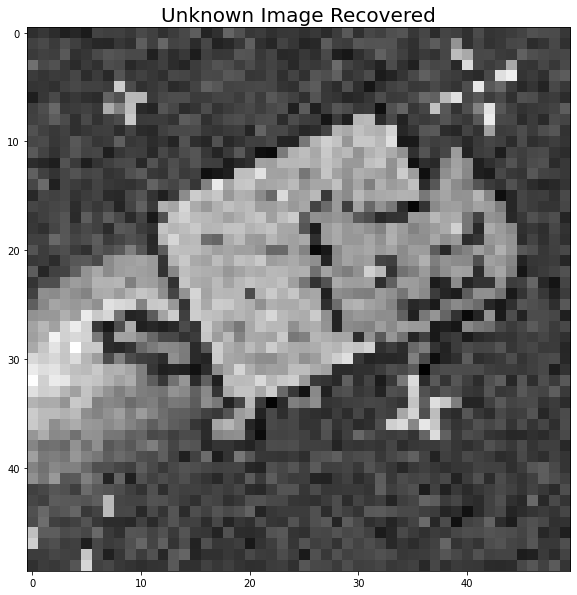

In [ ]:
### TASK 3: A MYSTERIOUS IMAGE
### File UnknownImage.py contains the measurement vector y and measurement matrix B
### for an unknown image of size 50x50 pixels. Read the file using numpy.load and 
### use your code for step 2(c) to reconstruct and visualize the unknown image. 

# Setup
B_unknown_path = '/content/drive/My Drive/Colab Notebooks/B.npy'
y_unknown_path = '/content/drive/My Drive/Colab Notebooks/y.npy'
B_unknown = np.load(B_unknown_path)
y_unknown = np.load(y_unknown_path)
Ny_unknown = Nx_unknown = 50
N_unknown = Ny_unknown * Nx_unknown
iD_unknown = construct_iDCT_Mat(Nx_unknown, Ny_unknown)

# Optimization 
A_unknown = np.matmul(B_unknown, iD_unknown)
x_unknown = cvx.Variable(N_unknown)
objective_unknown = cvx.Minimize( cvx.norm(x_unknown, 1) )
constraints_unknown =  [A_unknown*x_unknown == y_unknown]
problem_unknown = cvx.Problem( objective_unknown, constraints_unknown )
x_star_unknown = problem_unknown.solve(verbose=True, solver='CVXOPT', max_iter=1000, reltol=1e-2, featol=1e-2)
vecF_star_unknown = np.matmul(iD_unknown, x_unknown.value)
img_star_unknown = np.reshape(vecF_star_unknown, (Ny_unknown, Nx_unknown))

# Plotting
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(img_star_unknown, cmap='gray')
ax.set_title('Unknown Image Recovered', fontsize=20)

